### Using the restricted three-body problem to model the interactions between a galaxy and a point-mass perturber

In [247]:
import numpy as np
import matplotlib.pyplot as plt
G = 1   #here we use normalised units for the gravitational constant, mass, distance and time

In [248]:
def accel(x,y,x_c, y_c, x_p, y_p,M, m_p, e, x_dir = True):   

    '''
    Function for finding the cartesian acceleration of a star in a galaxy, when feeling a force from the galaxy
    centre of mass and a point perturber.

    Args:
        x (float): x coordinate of the star
        y (float): y coordinate of the star
        x_c (float): x coordinate of the galaxy centre of mass
        y_c (float): y coordinate of the galaxy centre of mass
        x_p (float): x coordinate of the point perturber
        y_p (float): y coordinate of the point perturber
        M (float): mass of the galaxy
        m_p (float): mass of the point perturber
        e (float): the softening constant
        x_dir (bool): if True, calculates the acceleration in x direction, otherwise calculates the acceleration in the y direction

    Returns:
        acceleration (float): the magnitude of the acceleration in either the x or y direction    
    '''

    D_C = np.sqrt((x-x_c)**2+(y-y_c)**2+e**2)  
    D_P = np.sqrt((x-x_p)**2 + (y-y_p)**2+e**2) 
    
    if x_dir:
        acceleration = -G*M*(x-x_c)/D_C**3 
        if m_p!=0:
            acceleration -= G*m_p*(x-x_p)/D_P**3
    else:
        acceleration = -G*M*(y-y_c)/D_C**3
        if m_p!=0:
            acceleration -= G*m_p*(y-y_p)/D_P**3
    return acceleration

def taylor_one_step(x,y,x_c, y_c, x_p, y_p, v_x, v_y, M, m_p, a, e):

    '''
    Uses the taylor expansion method to find the new position and speed of a star at each time-step

     Args:
        x (float): x coordinate of the star
        y (float): y coordinate of the star
        x_c (float): x coordinate of the galaxy centre of mass
        y_c (float): y coordinate of the galaxy centre of mass
        x_p (float): x coordinate of the point perturber
        y_p (float): y coordinate of the point perturber
        v_x (float): x component of the star velocity
        v_y (float): y component of the star velocity
        M (float): mass of the galaxy
        m_p (float): mass of the point perturber
        a (float): time-step
        e (float): the softening constant
    
    Returns:
        x_new (float): updated x coordinate of the star
        y_new (float): updated y coordinate of the star
        v_x_new (float): updated x component of the star velocity
        v_y_new (float): updated y component of the star velocity
    '''
        
    x_accel = accel(x,y,x_c, y_c, x_p, y_p,M, m_p, e, x_dir = True)
    y_accel = accel(x,y,x_c, y_c, x_p, y_p,M, m_p, e, x_dir = False)

    x_new = x+a*v_x + (a**2/2)*x_accel
    y_new = y+a*v_y + (a**2/2)*y_accel

    v_x_new = v_x + a*x_accel    
    v_y_new = v_y + a*y_accel

    return x_new,y_new,v_x_new, v_y_new

def leapfrog_one_step(x,y,x_c, y_c, x_p, y_p, v_x, v_y, M, m_p, a, e):

    '''
    Uses the leapfrog method to find the new position and speed of a star at each time-step

     Args:
        x (float): x coordinate of the star
        y (float): y coordinate of the star
        x_c (float): x coordinate of the galaxy centre of mass
        y_c (float): y coordinate of the galaxy centre of mass
        x_p (float): x coordinate of the point perturber
        y_p (float): y coordinate of the point perturber
        v_x (float): x component of the star velocity
        v_y (float): y component of the star velocity
        M (float): mass of the galaxy
        m_p (float): mass of the point perturber
        a (float): time-step
        e (float): the softening constant
    
    Returns:
        x_new (float): updated x coordinate of the star
        y_new (float): updated y coordinate of the star
        v_x_new (float): updated x component of the star velocity
        v_y_new (float): updated y component of the star velocity
    '''

    x_accel = accel(x,y,x_c, y_c, x_p, y_p,M, m_p, e, x_dir = True)
    y_accel = accel(x,y,x_c, y_c, x_p, y_p,M, m_p, e, x_dir = False)

    x_new = x + a*v_x + 0.5*a**2*x_accel
    y_new = y + a*v_y + 0.5*a**2*y_accel

    x_accel_new = accel(x_new,y_new,x_c, y_c, x_p, y_p,M, m_p, e, x_dir = True)
    y_accel_new = accel(x_new,y_new,x_c, y_c, x_p, y_p,M, m_p, e, x_dir = False)
    
    v_x_new = v_x + 0.5*a*(x_accel + x_accel_new)
    v_y_new = v_y + 0.5*a*(y_accel + y_accel_new)

    return x_new,y_new,v_x_new, v_y_new

def taylor_all_stars(x,y,v_x, v_y, v_p, m,m_p,a, e, n, initial, leapfrog = True):
    
    '''
    At each time-step calculates the new coordinates and velocities of each star using the function 
    taylor_one_step, then recalculates the position of the barycentre of the galaxy. Assumes the perturber moves 
    linearly, feeling no force from the galaxy, and the galaxy is initially stationary in the reference frame. 

    Args:
        x (array): starting x coordinate of the stars
        y (array): starting y coordinate of the stars
        v_x (array): starting x component of the stars's velocities
        v_y (array): starting y component of the stars's velocities
        v_p (float): velocity of the perturber
        m (array): masses of the stars
        m_p (float): mass of the point perturber
        a (float): time-step
        e (float): the softening constant
        n (int): number of time-steps
        initial (array): starting [x,y] position of the point perturber
        leapfrog (bool): if True, uses the leapfrog method, else uses the Taylor expansion method
    
    Returns:
        positions_array (array): array containing the [x,y] positions of each star at each time-step
        perturber_positions (array): array containing the [x,y] position of the perturber at each time-step
        barycentre (array): array containing the [x,y] position of the galaxy barycentre at each time-step
    '''

    #to store the data we create an array, with a row for each time step.
    positions_array = np.zeros((n, len(x), 2))
    perturber_positions = []
    barycentre = []
    M = np.sum(m)

    x_c = 0
    y_c = 0    #galaxy is initially centered at origin

    #Iterate over each time-step
    for i in range(n):

        barycentre.append([x_c, y_c])

        #Calculate the perturber position
        x_p = initial[0] + v_p*i*a
        y_p = initial[1] + v_p*i*a
        perturber_positions.append([x_p,y_p])

        #Iterate over each star
        for j in range(len(x)):
            if leapfrog == True:
                x_new,y_new, v_x_new, v_y_new = leapfrog_one_step(x[j],y[j],x_c, y_c, x_p, y_p, v_x[j], v_y[j], M, m_p, a, e)
            else:
                x_new,y_new, v_x_new, v_y_new = taylor_one_step(x[j],y[j],x_c, y_c, x_p, y_p, v_x[j], v_y[j], M, m_p, a, e)

            #Replace the last known position and velocity of each star with the recalculated values
            x[j] = x_new
            y[j] = y_new
            v_x[j] = v_x_new
            v_y[j] = v_y_new
            
            #Add the positions to the star array
            positions_array[i,j,0] = x_new
            positions_array[i,j,1] = y_new
        
        #Calculate the barycentre of the galaxy
        x_c = np.dot(x,m)/M
        y_c = np.dot(y,m)/M
            
    return positions_array, np.array(perturber_positions), np.array(barycentre)

In [249]:
def initialise_values(p, r_max, m_min, m_max):

    '''
    Given certain parameters of a galaxy, returns the initial conditions of the stars. This is done by modelling
    the initial positions of the stars randomly, with a distribution = 1/(r^2), as observed in real galaxies. The 
    masses are also randomly distributed, and the initial circular velocities found using v = (GM/r)^(1/2) where M
    is the total mass of the galaxy. From the circular velocities of the stars, the orbital period can be found. 
    The softening constant e = R_max p^(-1/2) is calculated.


    Args:
        p (int): number of stars
        r_max (float): radius of the galaxy
        m_min (float): minimum stellar mass of a star in the galaxy
        m_max (float): maximum stellar mass of a star in the galaxy

    Returns:
        x (array): starting x coordinate of the stars
        y (array): starting y coordinate of the stars
        v_x (array): starting x component of the stars's velocities
        v_y (array): starting y component of the stars's velocities
        m (array): masses of the stars 
        e (float): the softening constant
        T_min (array): the shortest orbital period of stars in the galaxy
        T_max (array): the longest orbital period of stars in the galaxy
        v_min (float): the speed of the slowest star in the galaxy
    '''

    r = np.linspace(0.1, r_max,p)
    m = np.random.uniform(m_min, m_max, p)
    e = max(r)/np.sqrt(p)     #set e relative to the size of the galaxy and number of syats

    print('Softening constant e = ', e)
    M = sum(m)
    
    v = np.sqrt(abs(G*M/r))         #find the initial circular velocities of the stars

    v_min = min(v)
    T_max = 2*np.pi*max(r)/min(v) 
    T_min = 2*np.pi*min(r)/max(v) 

    print('Shorted and longest orbital periods are ', T_min, T_max)

    theta = np.random.uniform(0, 2*np.pi, p)

    x =[r[j]*np.cos(theta[j]) for j in range(len(r))]
    y =[r[j]*np.sin(theta[j]) for j in range(len(r))]
    v_x = [-v[j]*np.sin(theta[j]) for j in range(len(r))]
    v_y = [v[j]*np.cos(theta[j]) for j in range(len(r))]

    return x,y, v_x, v_y, m, e, T_min, T_max, v_min

def plotting(stars, perturber, barycentre, n,c,b):

    '''
    Creates dot plots of the galaxies to show the effect of the encounter

    Args:
        stars (array): the x and y coordinates of each star at each time-step
        perturber (array): the x and y coordinates of the point perturber at each time-step
        barycentre (array): the x and y coordinates of the barycentre of the galaxy at each time-step
        n (int): the number of time-steps in the simulation
        c (int): the number of dot plots shown, equally spaced in time
        b (float): the spatial extent of the graph, centered around the galaxy centre of mass

    Returns:
        prints dot plots 
    '''

    for i in range(c):
        
        j = int(i*n/c)
        plt.figure(figsize = (5,5))

        x_com = barycentre[j,0]
        y_com = barycentre[j,1]

        plt.scatter(stars[j,:,0],stars[j,:,1], marker = 'o', s = 9, color = 'black')
        plt.scatter(perturber[j,0], perturber[j,1], color = 'red', label = 'Perturber position')
        plt.scatter(x_com, y_com, color = 'green', label = 'Barycentre')

        plt.xlim(-b/2+x_com,b/2+x_com)
        plt.ylim(-b/2+y_com,b/2+y_com)

        plt.legend(loc = "upper right")
        plt.show()

##### Set up the simulation

In [250]:
p = 300       #number of stars
r_max = 5     #radius of galaxy
m_min = 0.1   #minimum stellar mass in galaxy
m_max = 5     #maximum stellar mass in galaxy

#find the initial coordinates, positions, masses and periods of the stars
x,y,v_x, v_y, m,e, T_min, T_max, v_min = initialise_values(p, r_max, m_min,m_max)

mu = 2    #mass ratio of perturber to galaxy
V = 0.8     #ratio of perturber velocity to minimum star circular velocity

M = sum(m)
m_p = mu*M

#Set speed of the perturber to be some fraction of the speed of the slowest star
v_p = V*v_min

#Set the initial position of the perturber
initial =[-20,0]

#Set the duration of the simulation to be double the time taken for the perturber to reach its closest approach with the galaxy
T = 2*np.sqrt(initial[0]**2 + initial[1]**2)/v_p
print('Time scale of simulation is ', T)

n = 70000      #number of time steps
a = T/n
print('Time step is ',a)

Softening constant e =  0.28867513459481287
Shorted and longest orbital periods are  0.007130652362168269 2.521066319786528
Time scale of simulation is  4.0124016665651885
Time step is  5.7320023808074124e-05


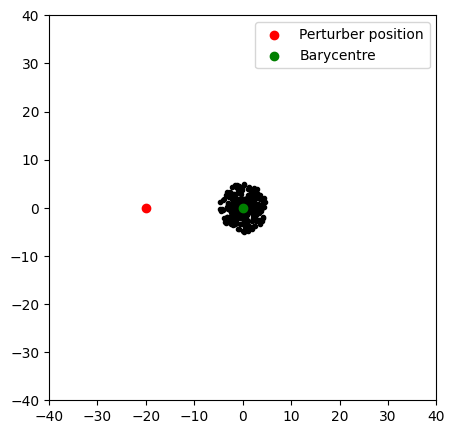

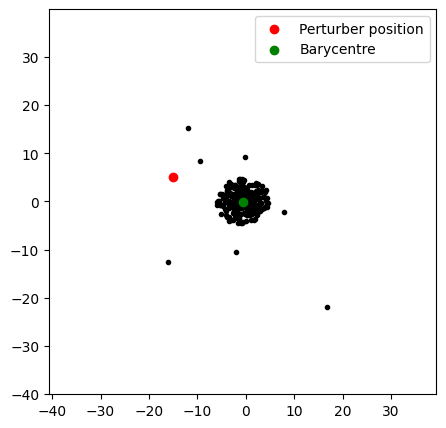

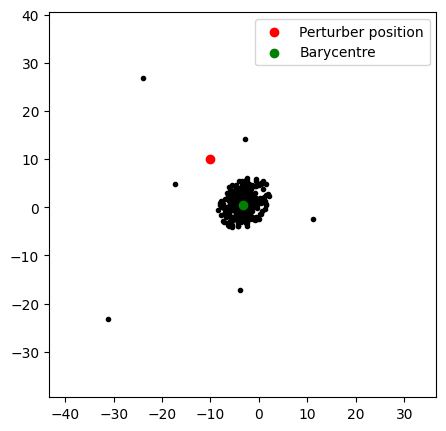

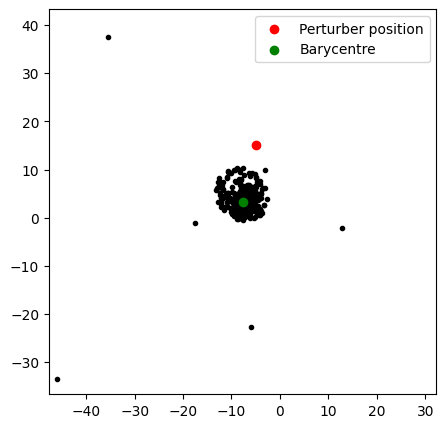

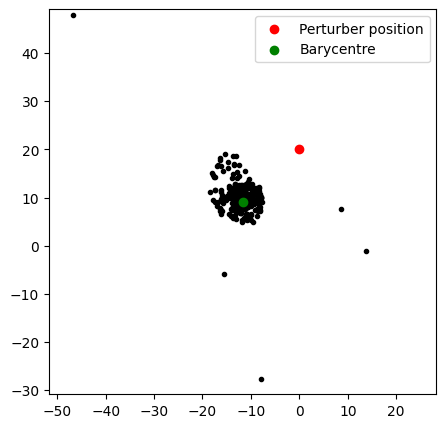

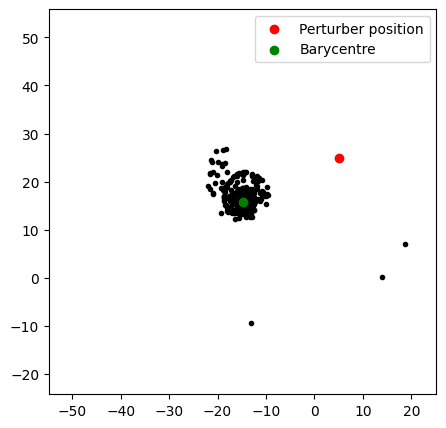

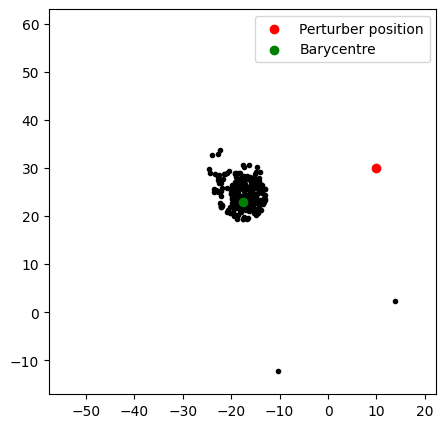

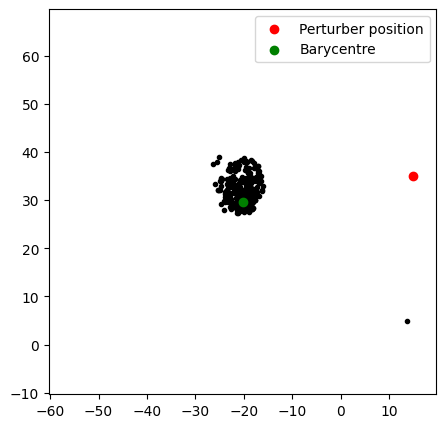

In [251]:
star_array, perturber, barycentre = taylor_all_stars(x,y,v_x,v_y,v_p, m,m_p,a, e, n, initial, True)

plotting(star_array,perturber,barycentre, n,8,80)